<div class="alert alert-block alert-success">
<b>Analytics test</b></div>
<div class="alert alert-block alert-success">
<b>Name:</b> Sayed Ibrahim.</div>

# 1 Introduction

This report is my answer to the analytics test. I used Jupyter Notebook to write this report and python for coding. Also, I used many standard libraries in Python such as pandas, numpy, statsmodels, matplotlib, and seaborn. The report consists of five sections. The first section is the introduction. After that, comes the reading data section. Following that is the data preprocessing section where I clean the data by handling data with Nan values and outliers. After that, the report presents my analysis starting with the three key performance measurements KPIs that I used. In the same section, the report shows an overall analysis of the data where I extract the main characteristics of the data and market segments. Also, this report provides a monthly analysis for each country along with the monthly forecasts for them. Follows that, is the regional analysis and the annual analysis. The last part is the resources allocation and flight capacities analysis.  

# 2 Reading the Data

The first step is upload and read the data. For this test, we have two data sets:`Data_test_Analytics.csv` and `Data_test_Analytics.csv`.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
import matplotlib.pyplot as plt
# read the Date:
flight_df = pd.read_csv("Data_test_Analytics.csv", parse_dates=["DepartureDate"])
rout_df = pd.read_csv("RouteInfo_test_Analytics.csv")
flight_df.sort_values(by=['Route','FlightNumber','DepartureDate'], inplace=True)
flight_df = flight_df.reset_index(drop=True)
flight_df.tail()

,Route,DepartureDate,FlightNumber,Hour,Capacity,Booked
1783,YYYCCC,2017-06-04,769,22,375.0,377.0
1784,YYYCCC,2017-06-11,769,22,375.0,372.0
1785,YYYCCC,2016-05-29,788,22,250.0,218.0
1786,YYYCCC,2016-06-05,788,22,250.0,234.0
1787,YYYCCC,2016-10-09,984,18,254.0,252.0


In [2]:
rout_df.head()

,Route,Country,Region
0,CCCYYY,France,Europe
1,LLLZZZ,UK,Europe
2,YYYAAA,Mexico,South
3,YYYCCC,France,Europe
4,AAAYYY,Mexico,South


# 3 Data Preprocessing

The first thing to do is to make sure we have clean data. In other words, we want the data to be without empty cells and outliers. 

## 3.1 Estimate the Values of NaN Cells
First, we check if we have Nan cell. As you can see below, the data file contains some empty cells under the Capacity and booked columns. I use the `df.interpolate()` function to get an estimated values for these empty cells.

In [3]:
# Find the rows with empty cell
null_data = flight_df[flight_df.isnull().any(axis=1)]
null_data

,Route,DepartureDate,FlightNumber,Hour,Capacity,Booked
237,CCCYYY,2016-07-04,279,11,NaN,289.0
628,CCCYYY,2016-07-08,693,17,NaN,345.0
1647,YYYCCC,2016-07-16,610,22,375.0,NaN
1717,YYYCCC,2016-07-16,688,21,NaN,290.0


In [4]:
flight_df = flight_df.interpolate()

Bellow, you can see that the estimated numbers for the NaN valued cells are reasonable.  

In [5]:
flight_df[627:630]

,Route,DepartureDate,FlightNumber,Hour,Capacity,Booked
627,CCCYYY,2016-07-01,693,16,345.0,306.0
628,CCCYYY,2016-07-08,693,17,345.0,345.0
629,CCCYYY,2017-06-28,699,18,345.0,335.0


## 3.2 Handling the outliers

I am focusing on two columns, the Capacity, and the Booked columns. Using the `df.describe()`, I can analyze and see if there are any outliers. 

In [6]:
flight_df.groupby(['Route'])['Capacity'].describe()

,count,mean,std,min,25%,50%,75%,max
Route,,,,,,,,
AAAYYY,73.0,290.835616,45.692211,250.0,250.0,250.0,345.0,345.0
CCCYYY,613.0,355.044046,34.417416,250.0,345.0,375.0,375.0,379.0
LLLZZZ,425.0,363.894118,27.788548,250.0,375.0,375.0,375.0,381.0
YYYAAA,72.0,287.291667,45.452479,250.0,250.0,250.0,345.0,345.0
YYYCCC,605.0,355.867769,34.089710,100.0,345.0,375.0,375.0,379.0


<div class="alert alert-block alert-info">
Clearly, Rout `YYYCCC` has at least one outlier data. 
</div>

In [7]:
flight_df.groupby(['Route'])['Booked'].describe()

,count,mean,std,min,25%,50%,75%,max
Route,,,,,,,,
AAAYYY,73.0,262.178082,50.114132,119.0,225.00,249.0,305.0,345.0
CCCYYY,613.0,338.796085,44.642763,143.0,324.00,349.0,374.0,380.0
LLLZZZ,425.0,333.905882,34.524746,195.0,321.00,343.0,356.0,381.0
YYYAAA,72.0,244.069444,49.761212,93.0,212.75,242.0,279.5,343.0
YYYCCC,605.0,329.719008,45.842197,80.0,310.00,340.0,366.0,397.0


Both Capacity and Booked data contain some outliers. For Capacity data, it is clear that `YYYCCC` has at least one outlier that has a capacity of `100`. The capacities for the rest of the route looks good. On the other hand, the Booked data seems to have many outliers. In `YYYCCC`, the data has two outliers: one with a value of `80` and the other with a value of `397`.

To handle this, we set the values to `Nan` for the outliers if the values are bellow `0.5` percentile or above `99.5`percentaile. Then, any flight with both Capacity and Booked value is `NaN`; we drop it form our data set.
 Finally, we use `df.interpolate()` to estimate the values for the remaining `Nan`.

In [8]:
def NaN_percentile(df, cul, Route, per):
    np_arr = df[df['Route'] == Route][cul].values
    l_perc_val = np.nanpercentile(np_arr, per)
    u_perc_val = np.nanpercentile(np_arr, 100 - per)
    df.loc[(df['Route'] == Route) & ((df[cul] >u_perc_val)|(df[cul] < l_perc_val)), cul] = np.nan
    return df

def get_unique_Routes(df):
    return list(df['Route'].unique())

In [9]:
for Route in get_unique_Routes(flight_df):
    flight_df = NaN_percentile(flight_df, 'Capacity', Route, 1)
    flight_df = NaN_percentile(flight_df, 'Booked', Route, 1)
flight_df.dropna(thresh=2, inplace=True)
flight_df.interpolate(inplace=True)
flight_df['Booked'] = flight_df['Booked'].astype(int)
flight_df['Capacity'] = flight_df['Capacity'].astype(int)
flight_df.groupby(['Route'])['Booked'].describe()

,count,mean,std,min,25%,50%,75%,max
Route,,,,,,,,
AAAYYY,73.0,265.164384,47.910511,191.0,225.00,249.0,309.0,345.0
CCCYYY,613.0,339.892333,41.619599,212.0,324.00,349.0,374.0,379.0
LLLZZZ,425.0,334.736471,32.201330,224.0,321.00,343.0,356.0,379.0
YYYAAA,72.0,245.000000,46.014082,118.0,212.75,242.0,279.5,335.0
YYYCCC,605.0,330.190083,43.265604,201.0,309.00,340.0,366.0,379.0


In [10]:
flight_df.groupby(['Route'])['FlightNumber'].count()

Route
AAAYYY     73
CCCYYY    613
LLLZZZ    425
YYYAAA     72
YYYCCC    605
Name: FlightNumber, dtype: int64

After doing the preprocessing,  the data looks better now. However, much more could be done to clean the data, but I think the data are good for the next steps.

## 3.3 Data Setting

Here, I am extracting the data to create the plots and do the analysis.

In [11]:
df_data = rout_df.merge(flight_df, left_on='Route', right_on='Route')
df_data['month'] = pd.to_datetime(df_data['DepartureDate']).dt.strftime('%m')
df_data['year'] = pd.to_datetime(df_data['DepartureDate']).dt.strftime('%y')
df_data['day of week'] = pd.to_datetime(df_data['DepartureDate']).dt.dayofweek
'-------------------------------------------------------------------------------------------------'
Data_2016 = df_data[df_data['year'] == '16']
Data_2017 = df_data[df_data['year'] == '17']
'-------------------------------------------------------------------------------------------------'
Monthly_2016 = Data_2016.groupby('month')['Booked'].sum()
Monthly_2017 = Data_2017.groupby('month')['Booked'].sum()
'-------------------------------------------------------------------------------------------------'
data_all = df_data.groupby(['year', 'month'])['Booked'].sum().reset_index(level=[0,1])
arr_all_monthly_booked = np.asarray(data_all['Booked'].astype(int)).tolist()
'-------------------------------------------------------------------------------------------------'
Europe = df_data[df_data['Region'] == 'Europe']
Monthly_Europe = Europe.groupby(['year', 'month'])['Booked'].sum().reset_index(level=[0,1])
arr_Europe_monthly_booked = np.asarray(Monthly_Europe['Booked']).tolist()
'-------------------------------------------------------------------------------------------------'
France = df_data[df_data['Country'] == 'France']
UK = df_data[df_data['Country'] == 'UK']
Mexico = df_data[df_data['Country'] == 'Mexico']
'-------------------------------------------------------------------------------------------------'
data_all = df_data.groupby(['year', 'month'])['Booked'].sum().reset_index(level=[0,1])
arr_all_monthly_booked = np.asarray(data_all['Booked']).tolist()
'-------------------------------------------------------------------------------------------------'
Monthly_France = France.groupby(['year', 'month'])['Booked'].sum().reset_index(level=[0,1])
arr_France_monthly_booked = np.asarray(Monthly_France['Booked']).tolist()
'-------------------------------------------------------------------------------------------------'
France_route_1 = France[France['Route'] == 'YYYCCC']
Monthly_France_route_1 = France_route_1.groupby(['year', 'month'])['Booked'].sum().reset_index(level=[0,1])
arr_Monthly_France_route_1_booked = np.asarray(Monthly_France_route_1['Booked']).tolist()
France_route_2 = France[France['Route'] == 'CCCYYY']
Monthly_France_route_2 = France_route_2.groupby(['year', 'month'])['Booked'].sum().reset_index(level=[0,1])
arr_Monthly_France_route_2_booked = np.asarray(Monthly_France_route_2['Booked']).tolist()
'-------------------------------------------------------------------------------------------------'
Monthly_UK = UK.groupby(['year', 'month'])['Booked'].sum().reset_index(level=[0,1])
arr_UK_monthly_booked = np.asarray(Monthly_UK['Booked']).tolist()
'-------------------------------------------------------------------------------------------------'
Monthly_Mexico = Mexico.groupby(['year', 'month'])['Booked'].sum().reset_index(level=[0,1])
arr_Mexico_monthly_booked = np.asarray(Monthly_Mexico['Booked']).tolist()
'-------------------------------------------------------------------------------------------------'
number_of_data = len(data_all['Booked'])
number_of_forecast_period = int(number_of_data/2)
data_index = list(range(1, number_of_data+1))
forecast_index = list(range(number_of_data, number_of_data + number_of_forecast_period))
'-------------------------------------------------------------------------------------------------'
df1 = pd.DataFrame(pd.date_range(start='2016-05-01', periods=6, freq='M'), columns=['date'])
df1['month'] = df1['date'].dt.month
df1['year_month'] = '16' + '-' + df1['month'].map(str)
df2 = pd.DataFrame(pd.date_range(start='2017-05-01', periods=6, freq='M'), columns=['date'])
df2['month'] = df2['date'].dt.month
df2['year_month'] = '17' + '-' + df2['month'].map(str)
df3 = pd.DataFrame(pd.date_range(start='2018-05-01', periods=6, freq='M'), columns=['date'])
df3['month'] = df3['date'].dt.month
df3['year_month'] = '18' + '-' + df3['month'].map(str)
Index = pd.concat([df1,df2,df3])

# 4. Analysis
This section presents my analysis. For analyzing the performance, I am using the following Key Performance Indicators KPIs: 
- Booking volume: measures that is the total number of booking for an area in a period. 
- Percentage of Growth: measures the increase of booked flights between in a period. 
- Booked to capacity: compares the number of booked and capacity of flights. 


I start by performing an overall analysis. The primary goal of that analysis is to get an overview of the data set and have a closer look at the size of market segments at the regional and country levels. Then, I will do the monthly analysis for each country. In the monthly analysis, I present the seasonal pattern, monthly booked volume, and the forecast for each country. After that, I give the yearly analysis. In the annual level to detect the annual trend, and the yearly rate of growth. Finally, I provide the analysis for the capacities.   

## 4.1 Overall Analysis
First, we have a look in our data, and then we look at the market segments size at the regional and country level. 

The data set contains information for 1788 flights.

In [12]:
df_data.shape

(1788, 11)

The Data set contains information for two regions: Europe and South. In Europe, we have the data for two countries France, and the UK, and in the south, we have the data for one, which is Mexico. For France and Mexico, the data set contains two routs and one route for the UK. Below is the number of flights for each route. The total number of booking is around six hundred thousands. 


In [13]:
df_data.groupby(['Region','Country','Route'])['Booked'].count()

Region  Country  Route 
Europe  France   CCCYYY    613
                 YYYCCC    605
        UK       LLLZZZ    425
South   Mexico   AAAYYY     73
                 YYYAAA     72
Name: Booked, dtype: int64

In [14]:
df_data['Booked'].sum()

587379

Next, I analyze the market segment. The goal is to understand the size of each region and country. Bellow, we see two pie charts illustrating the percentage of areas of the booked flights. The graphs show that:

- In term of regions, Europ is the most significant market segment, where Europ makes 93.7%, and South region makes 6.3% of the total bookings.
- In term of countries, France is the most significant market segment with a total of 60.5%. Second, comes the UK which makes 24.2% of the market place. Finally, Mexico makes 6.3% of the market place.  

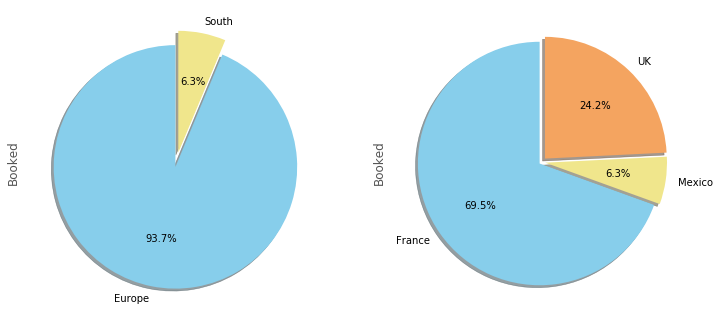

In [15]:
fig1 = plt.figure()
from matplotlib import style
style.use('ggplot')
ax1_1 = fig1.add_subplot(121)
ax1_2 = fig1.add_subplot(122)
df_data.groupby(['Region'])['Booked'].sum().plot(kind='pie', startangle=90, ax=ax1_1, legend=False, explode=(0.04,0.08), autopct='%0.1f%%', shadow=True,figsize=(12, 6), colors=['skyblue', 'khaki'] )
df_data.groupby(['Country'])['Booked'].sum().plot(kind='pie', startangle=90, ax=ax1_2, legend=False, explode=(0.02,0.03,0.04), autopct='%0.1f%%', shadow=True, colors=['skyblue', 'khaki', 'sandybrown'])

For France and Mexico, we have two-way flights. It looks that the numbers of bookings are evenly distributed between the routs.

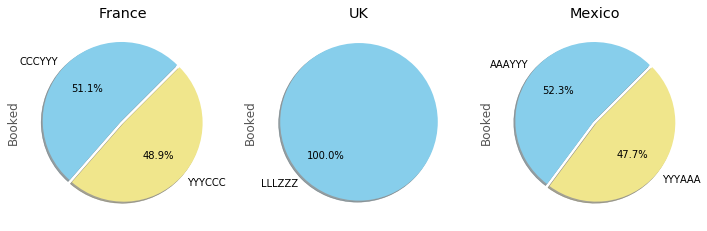

In [16]:
fig2 = plt.figure()
ax2_1 = fig2.add_subplot(131)
ax2_2 = fig2.add_subplot(132)
ax2_3 = fig2.add_subplot(133)
France.groupby(['Route'])['Booked'].sum().plot(kind='pie', startangle=45, ax=ax2_1, legend=False, explode=(0.02,0.02), autopct='%0.1f%%', shadow=True,figsize=(12, 6), colors=['skyblue', 'khaki'], title = 'France' )
UK.groupby(['Route'])['Booked'].sum().plot(kind='pie', startangle=45, ax=ax2_2, legend=False, autopct='%0.1f%%', shadow=True, colors=['skyblue', 'khaki', 'sandybrown'], title = 'UK')
Mexico.groupby(['Route'])['Booked'].sum().plot(kind='pie', startangle=45, ax=ax2_3, legend=False, explode=(0.02,0.02), autopct='%0.1f%%', shadow=True, colors=['skyblue', 'khaki', 'sandybrown'], title = 'Mexico')

## 4.2 Monthly Analysis and Forecast for Each Country
This section presents the monthly analysis for each country. I start with the monthly analysis for each country because I decided to make the forecast based on the monthly number of flights booked for each country. Then, I obtain the yearly prediction using the monthly forecasts. In other words, the annual forecast is the cumulative monthly forecasts.

The reason to do the forecast for each country is that the demand at each country behaves differently. I do the monthly forecast because there is less noise in the monthly charts compared to the daily and weekly charts. So, it would be easier to present the work. 

Below are the monthly analysis and forecasts for France, Mexico, and the UK. 

### 4.2.1 France
The chart below illustrates the monthly number of booking for France. The seasonal pattern is obvious. The cycle starts in May and ends in October every year. As shown in the figure, July, August, and September are the high seasons. On the other hand, May and October are the low seasons. in general there is an upward trend and six-month seasonal cycle. 

I used winter Hults method to forecast for 2018. The forecast expects higher highs and higher lows for 2018. Since I have the data for two cycles only, I did not validate the forecast model. So, if more data is available, then I could divide the data into two parts training data and testing data. Then I could do further analysis to evaluate the forecasting model. 

The line chart below expresses the number of bookings each month. In the graph, the horizontal line corresponds to the date (YY-MM). The vertical axis corresponds to the number of booking. The line for 2016 & 2017 is obtained from the historical data. 

Overall, the chart shows a continuous growth from May to August and declines in September and October. The number of bookings plummets in October.  In general, July, August, and September are the high seasons and, and October are the low seasons. 

Note that in 2016 June is a low season, whereas in 2017 it is not. Further analysis is needed to verify the forecast for June 2018. If the increase in June is due to a particular event, then we should reduce the estimate for that month in 2018. 

Also, This analysis could be done for each route, but I decided to the analysis of the country based to keep it simple. 

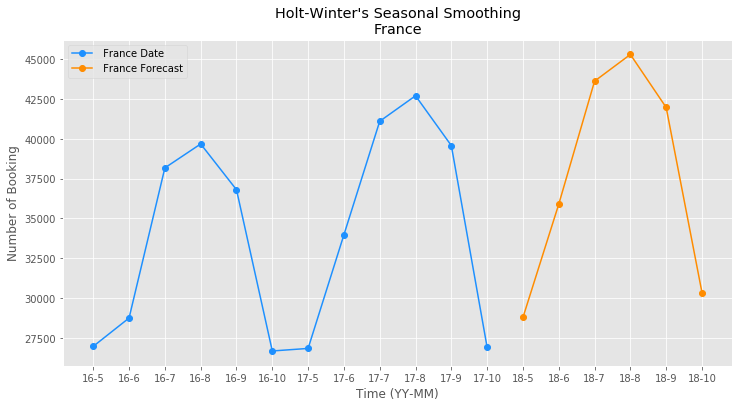

In [17]:
model_France = ExponentialSmoothing(arr_France_monthly_booked,seasonal_periods=number_of_forecast_period, trend='add', seasonal='add')
model_France_fit = model_France.fit(use_boxcox ='log')
forecast_France = pd.Series(np.array(model_France_fit.forecast(len(forecast_index))))
figFrance, ax_France = plt.subplots(figsize=(12, 6))
ax_France.plot(Index[:-6]['year_month'], arr_France_monthly_booked, marker='o', color='dodgerblue', label=" France Date");
ax_France.plot(Index[-6:]['year_month'],forecast_France, marker='o', color='darkorange', label=" France Forecast");
ax_France.set_title("Holt-Winter's Seasonal Smoothing\nFrance");
plt.xlabel('Time (YY-MM)')
plt.ylabel('Number of Booking')
plt.legend()
plt.show()

### 4.2.2 UK
The below chart presents the monthly booking for the UK. July and August are the high seasons and May, September, and October are the low seasons. The peak time is in August. In contrast to France, the number of booking dips in September. Every year, there is a sharp increase in May and June and a steady decline in October.

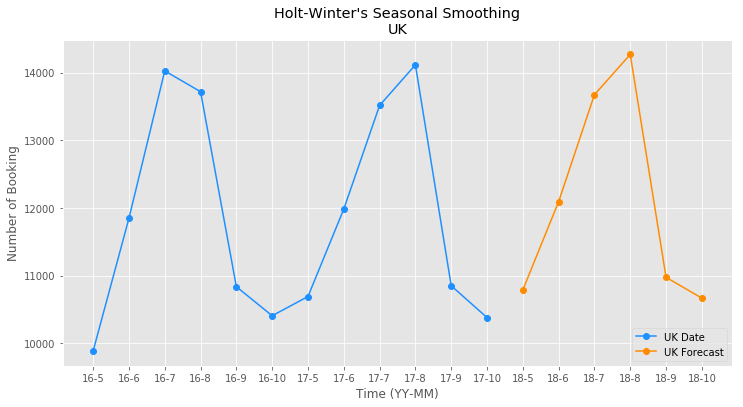

In [18]:
model_UK = ExponentialSmoothing(arr_UK_monthly_booked,seasonal_periods=number_of_forecast_period, trend='add', seasonal='add')
model_UK_fit = model_UK.fit(use_boxcox ='log')
forecast_UK = pd.Series(np.array(model_UK_fit.forecast(len(forecast_index))))
figUK, ax_UK = plt.subplots(figsize=(12, 6))
ax_UK.plot(Index[:-6]['year_month'], arr_UK_monthly_booked, marker='o', color='dodgerblue', label="UK Date");
ax_UK.plot(Index[-6:]['year_month'],forecast_UK, marker='o', color='darkorange', label="UK Forecast");
ax_UK.set_title("Holt-Winter's Seasonal Smoothing\nUK");
plt.xlabel('Time (YY-MM)')
plt.ylabel('Number of Booking')
plt.legend()
plt.show()

### 4.2.3 Mexico 
The chart for Mexico looks different. Seasonality is less distinct, but the upward trend is clear.  Even though that seasonality is not clear, but the graph has a seasonal pattern. The cycle starts in May and ends in October. However, the cycle consists of two dips and three peaks. The chart shows dips in June and September and peaks in May, August, and October. Note that there is a massive rate of growth in Mexico. 

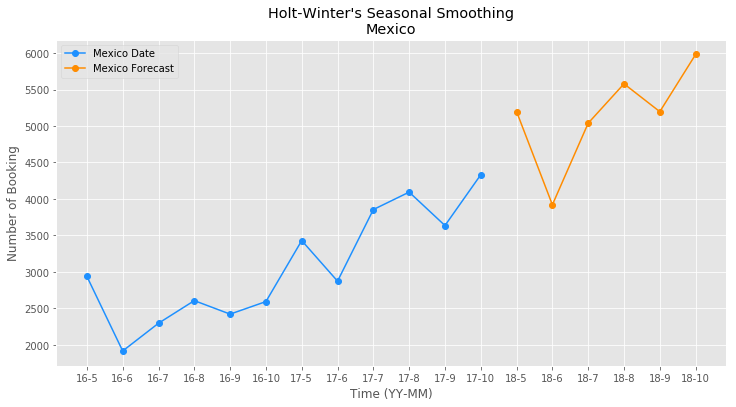

In [19]:
model_Mexico = ExponentialSmoothing(arr_Mexico_monthly_booked,seasonal_periods=number_of_forecast_period, trend='add', seasonal='add')
model_Mexico_fit = model_Mexico.fit(use_boxcox ='log')
forecast_Mexico = pd.Series(np.array(model_Mexico_fit.forecast(len(forecast_index))))
figUK, ax_Mexico = plt.subplots(figsize=(12, 6))
ax_Mexico.plot(Index[:-6]['year_month'], arr_Mexico_monthly_booked, marker='o', color='dodgerblue', label="Mexico Date");
ax_Mexico.plot(Index[-6:]['year_month'],forecast_Mexico, marker='o', color='darkorange', label="Mexico Forecast");
ax_Mexico.set_title("Holt-Winter's Seasonal Smoothing\nMexico");
plt.xlabel('Time (YY-MM)')
plt.ylabel('Number of Booking')
plt.legend()
plt.show()

## 4.3 Regional Based Monthly Analysis
Here, we analyze the monthly bookings for Europe. For the South region, Since it has one country, the analysis is already done for Mexico. The goal is to have an overall view of market behavior in Europe. 

The line chart below expresses the number of bookings from May to October in 2016 and 2017. The horizontal axis corresponds to the dates, and the vertical axis corresponds to the number of booking. 

The chart shows that May and October are low seasons. On the other hand, July, August, and September are high seasons. The number of booking peaks in August and dips in October. 

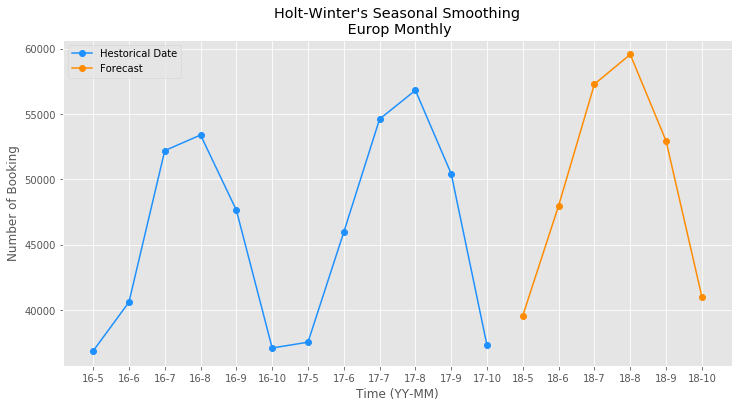

In [20]:
#Europ montly chart
forecast_Europ = forecast_France.add(forecast_UK, fill_value=0)
figEurop, ax_Europ = plt.subplots(figsize=(12, 6))
ax_Europ.plot(Index[:-6]['year_month'], arr_Europe_monthly_booked, marker='o', color='dodgerblue', label="Hestorical Date");
ax_Europ.plot(Index[-6:]['year_month'],forecast_Europ, marker='o', color='darkorange', label="Forecast");
ax_Europ.set_title("Holt-Winter's Seasonal Smoothing\n Europ Monthly");
plt.xlabel('Time (YY-MM)')
plt.ylabel('Number of Booking')
plt.legend()
plt.show()

## 4.4 Total Monthly Booking Analysis

Let's analyze the number of flights booking at each month. Our goal is to understand the overall behavior of the market every month from May to October for 2016 and 2017. Also, to detect the overall monthly trends and seasonal patterns. Finally, to predict the monthly booking volume from May to October for 2018. 

 To forecast 2018, I used the results from the monthly forecast of each country. For each month, We take the cumulative forecasts of all country.

The horizontal data shows a clear seasonal pattern. Overall, the chart shows a continuous growth from May to August and declines in September and October. In 2016, the number of booked flights took off in July and reached a peak in August. In 2017, sales took off in June and July and reached a peak in August. Every year, the number of booked flights plummets in October. Nex year in 2018, the forecasting method predicts similar behavior to the historical data. In general, July, August, and September are the high seasons and, and October are the low seasons.

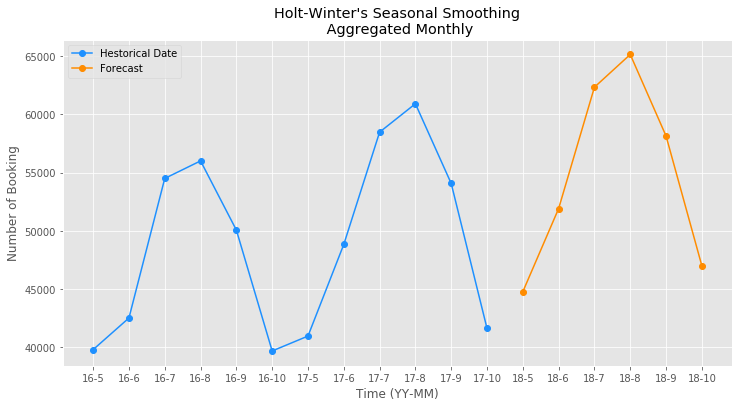

In [21]:
# create class, fit model, forecast, plot
forecast_all = forecast_Europ.add(forecast_Mexico, fill_value=0)
figall, ax_all = plt.subplots(figsize=(12, 6))
ax_all.plot(Index[:-6]['year_month'], arr_all_monthly_booked, marker='o', color='dodgerblue', label="Hestorical Date");
ax_all.plot(Index[-6:]['year_month'],forecast_all, marker='o', color='darkorange', label="Forecast");
ax_all.set_title("Holt-Winter's Seasonal Smoothing\n Aggregated Monthly");
plt.xlabel('Time (YY-MM)')
plt.ylabel('Number of Booking')
plt.legend()
plt.show()

## 4.5 Annual Booking Analysis

Let's analyze the annual volume and yearly rate of growth per country. Bellow, the bar chart shows the yearly number of bookings for France, the UK, and Mexico in 2016 and 2017. For 2018, I obtained the results from the monthly forecast for each country. Overall, there is an increase in volume for each country. In 2017, Mexico had the highest annual rate of growth with a growth of 50%. Also, France has a yearly growth of 7%. However, the volume in the UK looks steady with an annual increase of 1%. The forecast expects 33% growth in Mexico, 7% in France, and 1% growth in the UK. In term of volume, we estimate an increase of 15 thousand in France, nin thousand in the UK, nine hundred in Mexico. 

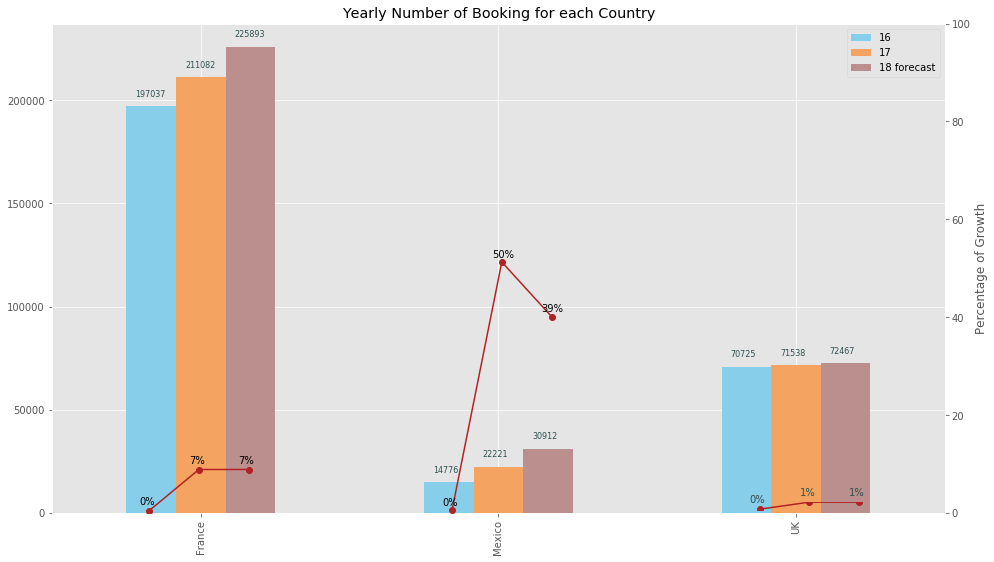

In [22]:
plt.close('all')
# get the percentage of growth for each country
def percentage_growth(data):
    Data2 = data.copy()
    last_year = '16'
    for row in data.iterrows():
        country, booked = row
        for years, amount in booked.items():
            if years == '16':
                Data2.at[country, years] = 0
                last_year = '16'
                continue
            else:
                Data2.at[country, years] = 100 * (data.at[country, years] - data.at[country, last_year]) / (
                data.at[country, last_year])
                last_year = years
    return Data2

forcast_data = pd.DataFrame()
forecast_France_2018 = sum(forecast_France)
forcast_data.loc['France', '18 forecast'] = int(forecast_France_2018)
forecast_UK_2018 = sum(forecast_UK)
forcast_data.loc['UK', '18 forecast'] = int(forecast_UK_2018)
forecast_Mexico_2018 = sum(forecast_Mexico)
forcast_data.loc['Mexico', '18 forecast'] = int(forecast_Mexico_2018)
data = df_data.groupby(['Country','year'])['Booked'].sum().unstack()
data = pd.concat([data, forcast_data], axis=1, sort=False).astype(int)
Data2 = percentage_growth(data)
fig_Country_year, ax_Country_year = plt.subplots(figsize=(16,9));
ax_Country_year_y2 = ax_Country_year.twinx()  # instantiate a second axes that shares the same x-axis
ax_Country_year_y2.set_ylabel('Percentage of Growth')  # we already handled the x-label with ax1
ax_Country_year_y2.set_ylim(bottom=0, top=100)
ax_Country_year = data.plot(ax=ax_Country_year, kind='bar', color=['skyblue','sandybrown', 'rosybrown'], title='Yearly Number of Booking for each Country')
for p in ax_Country_year.patches:
    ax_Country_year.annotate(str(p.get_height()), (p.get_x() + 0.03, p.get_height() + 5000), size=8, color='darkslategrey')
Data2 = Data2.T
# add is an inset axes for the France
left, bottom, width, height = [0.205, 0.125, 0.095, (Data2.iloc[2, 0]/100)]
ax_Country_year2 = fig_Country_year.add_axes([left, bottom, width, height])
ax_Country_year2.plot(Data2['France'], color='firebrick', marker='o')
ax_Country_year2.patch.set_alpha(0.0)
ax_Country_year2.axis('off')
x = np.arange(3)
for i in range(len(x)):
    ax_Country_year2.text(x=x[i]-0.2, y=Data2.iloc[i , 0] + 1, s=str(int(Data2.iloc[i , 0])) + '%', size=10, color='k')
# add is an inset axes for Mexico
left, bottom, width, height = [0.468, 0.11, 0.095, 1.08*(Data2.iloc[2, 1]/100)]
ax_Country_year3 = fig_Country_year.add_axes([left, bottom, width, height])
ax_Country_year3.plot(Data2['Mexico'], color='firebrick', marker='o')
ax_Country_year3.patch.set_alpha(0.0)
ax_Country_year3.axis('off')
x = np.arange(3)
for i in range(len(x)):
    ax_Country_year3.text(x=x[i]-0.2, y=Data2.iloc[i ,1] + 1, s=str(int(Data2.iloc[i ,1])) + '%', size=10, color='k')
# add is an inset axes for UK
left, bottom, width, height = [0.735, 0.13, 0.095, 1.2*(Data2.iloc[2, 2]/100)]
ax_Country_year4 = fig_Country_year.add_axes([left, bottom, width, height])
ax_Country_year4.plot(Data2['UK'], color='firebrick', marker='o')
ax_Country_year4.patch.set_alpha(0.0)
ax_Country_year4.axis('off')
x = np.arange(3)
for i in range(len(x)):
    ax_Country_year4.text(x=x[i]-0.2, y=Data2.iloc[i,2] + 1, s=str(int(Data2.iloc[i,2])) + '%', size=10, color='darkslategrey')
ax_Country_year_y2.grid(b=False)

Let's have a look at the annual bar chart to analyze the overall growth of the sales which is the number of bookings at each year. In the bar chart below, We can see that the total bookings are increasing every year. Also, I used the monthly forecast for each country to get the total booking forecasts for 2018. The figure shows an increase in the number of booking in 2018. Data shows an increasing trend in term of the number of booking every year. The volume of booking is around three hundred thousand every year. In 2016, the booking rate of growth was 7%, and for 2018 we expect the same percentage of growth. That is equivalent to having twenty-five thousands more booking in 2018.

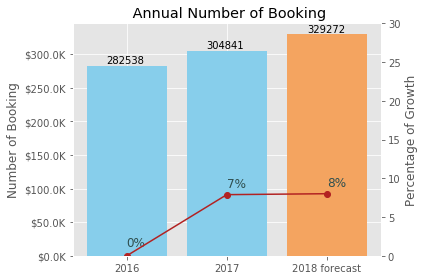

In [23]:
yearly_booked = df_data.groupby(['year'])['Booked'].sum().reset_index(level=[0])
arr_yearly_booked = np.asarray(yearly_booked['Booked']).tolist()
years_index = ['2016','2017','2018']

arr_yearly_Forcast = []
arr_yearly_Forcast.append(forecast_France_2018 + forecast_UK_2018 + forecast_Mexico_2018)

from matplotlib.ticker import FuncFormatter
x = np.arange(3)
data1 = list(arr_yearly_booked) + list(arr_yearly_Forcast)
data2=[]
data2.append(0)
data2 = data2 + [(100*(data1[x] - data1[x-1])/data1[x-1]) for x in range(1,len(data1))]

def thousands(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fK' % (x * 1e-3)

formatter = FuncFormatter(thousands)

fig_yearly , ax_yearly = plt.subplots()
ax_yearly2 = ax_yearly.twinx()  # instantiate a second axes that shares the same x-axis
ax_yearly2.set_ylabel('Percentage of Growth')  # we already handled the x-label with ax1

ax_yearly2.set_ylim(bottom=0, top=30)
for i in range(len(x)):
    ax_yearly.text(x=x[i]+0.0, y=data2[i]*11000 + 15000, s=str(int(data2[i]))+'%', size=12, color='darkslategrey')
ax_yearly2.plot(x, data2, marker='o', color='firebrick', label="Rate of Growth")

ax_yearly.yaxis.set_major_formatter(formatter)
for i in range(len(x)):
    ax_yearly.text(x=x[i]-0.2, y=data1[i] + 4000, s=int(data1[i]), size=10, color='k')

ax_yearly.bar(x, data1, color=['skyblue','skyblue','sandybrown'], tick_label=['2016','2017','2018 forecast'])
ax_yearly.set_ylabel('Number of Booking')
ax_yearly2.grid(b=False) # turn off grid #2
plt.title(" Annual Number of Booking");
fig_yearly.tight_layout()

## 4.6 Booking to Capacity Analysis

The goal is to evaluate flights utilizations and flights Schedule. For that, in this section, we define the Booking to Capacity Ratio (CBR). 
$$ BCR = \frac{Booked}{Capacity} $$
If BCR is equal to one, then the flight is completely utilized which is the ideal case for the flight. If CBR is less than one, there were some seats not booked. That means that the airplane is not fully utilized. If BCR is greater than one, then the airline had to cancel some bookings. That is because of a shortage of space. That means that the airline missed some opportunities. 

Below are the statistics for the BCR. In average, 92.7% of the airplane is booked in 2016 and 93.7% in 2018. Also, in term of medians 95% of the aircraft booked in both years. 

In [24]:
df_data['BCR'] = df_data['Booked']/df_data['Capacity']
df_data.groupby(['year'])['BCR'].describe(percentiles=[0.01, 0.05, .25, .5, .75, 0.95, 0.99])

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
year,,,,,,,,,,,,
16,865.0,0.927053,0.083256,0.556522,0.654446,0.768626,0.886957,0.950725,0.989333,1.005333,1.010667,1.364
17,923.0,0.937376,0.075751,0.472000,0.656348,0.792000,0.904174,0.950725,0.994667,1.010667,1.015793,1.348


Also, the histogram shows the distribution of the BCR. The histogram shows that the majority of flights have BCR close to one and very few have BCR less than 80%. Also, The second histogrm showe that, there was improvment in 2017. 

Text(0.5, 0, 'BCR')

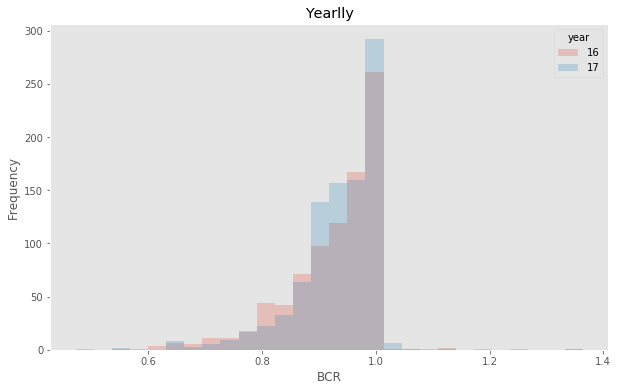

In [25]:
df_data.pivot(columns='year', values='BCR').plot.hist(bins=28, figsize=(10,6), alpha=0.25, grid=False)
plt.title('Yearlly')
plt.xlabel('BCR')

To illustrate and visualize the Booked to Capacity Ratio in a monthly bases, we used the Box plot. The below box represents BCR for 2016 and 2017. In general, The airline is doing better in 2017 compared to 2016 in term of BCR every month except in August. This is very clear in May and September. Also, In 2016, the airline had more opportunity costs compare to 2017. For the next year, the team should try to improve the BCR for July and August. 

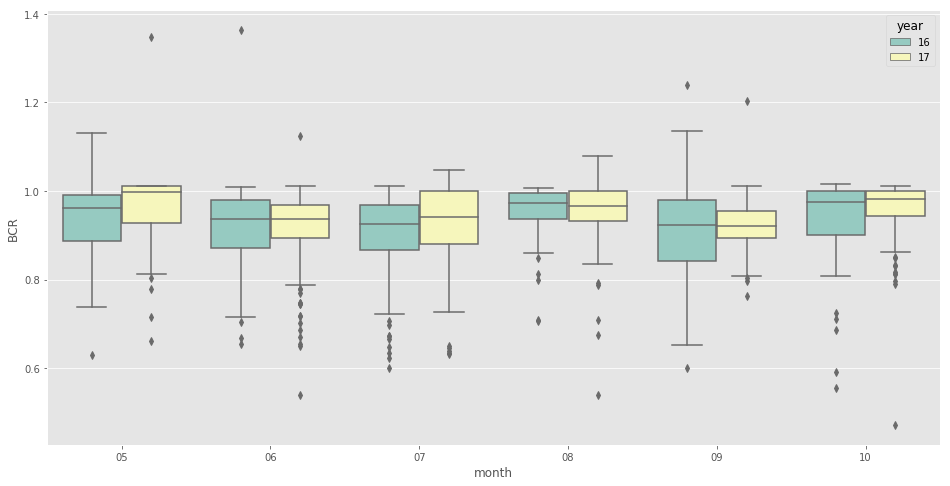

In [26]:
import seaborn as sns
plt.figure(figsize=(16, 8))
ax = sns.boxplot(x="month", y="BCR",  hue="year", data=df_data, palette="Set3")

# 5 Conclousion

This report provides my analysis and the codes that I used for that. This report is written in Jupyter Notebook. For the analysis, I used python and many of the standard libraries in python such as pandas, numpy, matplotlib, and statsmodels. The report starts by cleaning the data. Three KPIs are used in the analysis the volume of booked, rate of growth and booked to capacity ration. The analysis starts by analyzing the monthly booking for each country. I observed that the seasonal cycle begins in May and ends in October. Overall, the season starts low in May, reaches the peak in August, and dips in October. In Mexico, we found a massive rate of growth.
Moreover, I presented the monthly forecast for each country for 2018. Then I gave the yearly analysis where I observe that the annual growth is 7% and expected 8% growth for 2018. Finally, the report presents Booked to capacity evaluations. The results show that flight utilization on average is 92.7% in 2016 and 93.7% in 2017. Also, the data shows an improvement in 2017 compared to 2016 in term of airplane utilization.
